In [6]:
import os, json
from Tint_Matlab import *
import struct
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import SignalProcessing as sp
%matplotlib inline
import re
%load_ext line_profiler
import profile
import time
import mmap
import contextlib
import numpy.distutils.system_info as sysinfo

In [7]:
def get_sample_indices(channel_number, samples):
    remap_channel = get_remap_chan(channel_number)
    
    indices_scalar = np.multiply(np.arange(samples), 64)
    sample_indices = indices_scalar + np.multiply(np.ones(samples), remap_channel)
    
    #return np.array([remap_channel, 64 + remap_channel, 64*2 + remap_channel])
    return (indices_scalar + np.multiply(np.ones(samples), remap_channel)).astype(int)

def get_valid_pos_indices(valid_iterations):
    """This method will produce the indices of the unpacked byte data relating to the valid positions,
    as well as the the iteration (packet) number that will be later used to calculate the starting position"""
    
    num_pos_values = 9
    position_offset = 4  # number of values before the position values start

    indices = np.arange(num_pos_values)  # there are 8 position words and 1 frame count for the time
    indices = np.tile(indices, (1, len(valid_iterations)))
    indices = indices.flatten()

    offset_indices = valid_iterations*213 + position_offset
    offset_indices = np.tile(offset_indices,(num_pos_values,1))
    offset_indices = offset_indices.flatten(order='F')
    
    return indices + offset_indices


def find_n(iterations, optimal=1000):
    n = optimal
    
    while True:
        if iterations % n == 0:

            return n
        else:
            n -= 1
    return 'abort'

def get_valid_pos_bytes(valid_iterations):
    
    """This function works, but the strategy I use didn't. I was going to slice the bytearray like you would
    a numpy array but that didn't work"""
    data_byte_len = 20
    indices = np.arange(data_byte_len)
    indices = np.tile(indices, (1, len(valid_iterations)))
    indices = indices.flatten()

    offset_indices = np.arange(iterations)
    offset_indices = valid_iterations*432 + 12
    offset_indices = np.tile(offset_indices,(data_byte_len,1))
    offset_indices = offset_indices.flatten(order='F')
    
    indices = indices + offset_indices
    indices.reshape((-1, data_byte_len))
    
    return indices[:,[0,-1]]
    

In [8]:
def get_raw_pos(bin_filename, mode='mmap'):
    """This will get the raw position data from the .bin file in the following format:
    video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value
    
    The video timestamp is the time since the camera has been turned on, thus this value is
    irrelevent
    
    The .bin file is written of packets of 432 bytes containing position data, three samples of 
    electrophys data (per channel), and etc.
    
    A packet only has a valid position if it has an "ADU2" tag in the header. You'll notice that
    the positions are sampled at twice the normal rate to avoid aliasing.
    
    There are two modes, one will use memory mapping, and the other will not: 'mmap' or 'non'
    """
    pos_sample_num = 0
    
    byte_count = os.path.getsize(bin_filename)
    bytes_per_iteration = 432
    iteration_count = int(byte_count/bytes_per_iteration)  
    sample_count = iteration_count * 192  # each iteration has 192 samples (64*3)
    
    optimal_iteration = 1000000
    if optimal_iteration >= iteration_count:
        simul_iterations = iteration_count
    else:
        simul_iterations = find_n(iteration_count, optimal=optimal_iteration)

    n = int(iteration_count / simul_iterations) # finds how many loops to do
    byte_chunksize = int(simul_iterations * bytes_per_iteration)

    DaqFs = 48000
    duration = iteration_count * 3 / DaqFs
    duration = np.ceil(duration)
    
    pos_Fs = 50
    n_samples = int(duration * pos_Fs)
    
    #Reading the Data
    
    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16
    
    raw_pos = np.array([]).astype(float)
    
    if sysinfo.platform_bits != 64:
        mode = 'non'  # do not mmap with a 32 bit python
    
    with open(bin_filename, 'rb') as f:
        
        if mode == 'mmap':
            # we will use memory mapped objects
            
            with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as m:
                num_iterations = int(len(m)/bytes_per_iteration)
                
                byte_ids = np.ndarray((num_iterations,), 'S4', m, 0, 432)
                
                pos_bool = np.where(byte_ids == b'ADU2')  # valid position packets have an ADU2 header b'ADU2' in bytes
                
                valid_iterations = np.arange(len(byte_ids))[pos_bool]  # getting the packet number

                time_stamp = np.ndarray((num_iterations,), np.uint32, m, 12, 432)[pos_bool].reshape((-1,1))  # gettinge the time stamp data
                
                raw_pos = np.ndarray((num_iterations,), (np.uint16, (1,8)), m, 16, (432,)).reshape((-1,8))[pos_bool][:]
             
                raw_pos = np.hstack((valid_iterations.reshape((-1,1)), time_stamp, raw_pos)).astype(float)  # stacking all these values to create one matrix

        else:
            
            # in some cases using memory mapping will be slow, such as using 32 bit python
            
            iteration_start = 0
            # we will iterate
            for i in range(n):
                data = f.read(byte_chunksize)
                num_iterations = int(len(data)/bytes_per_iteration)

                byte_ids = np.ndarray((num_iterations,), 'S4', data, 0, 432)

                pos_bool = np.where(byte_ids == b'ADU2')  # valid position packets have an ADU2 header b'ADU2' in bytes

                valid_iterations = np.arange(len(byte_ids))[pos_bool]  # getting the packet number

                time_stamp = np.ndarray((num_iterations,), np.int32, data, 12, 432)[pos_bool].reshape((-1,1))  # gettinge the time stamp data
                
                positions = np.ndarray((num_iterations,), (np.int16, (1,8)), data, 16, (432,)).reshape((-1,8))[pos_bool][:]
                
                i = np.add(valid_iterations, iteration_start)  # offsetting the samples depending on the chunk number (n)

                positions = np.hstack((i.reshape((-1,1)), time_stamp, positions)).astype(float)  # stacking all these values to create one matrix
                
                iteration_start += simul_iterations

                if len(raw_pos) != 0:

                    raw_pos = np.vstack((raw_pos, positions))

                else:

                    raw_pos = positions

        
        raw_pos[:,1] = np.divide(raw_pos[:,1], 50)  # converting from a frame count to a time value in seconds
        
        # raw_pos is structured as: packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value 

        # the X and Y values are reverse piece-wise so lets switch the format from 
        # packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value
        # to 
        # packet #, video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value
        
        raw_pos[:, 2:6] = raw_pos[:, [3, 2, 5, 4]] 
        
         # find the first valid sample, since the data is sampled at 48kHz, and there are 3 samples per packet, the packet
        # rate is 16kHz. The positions are sampled at 50 Hz thus there is a valid position ever 320 packets. The valid position
        # will essentially take the last ADU2 headered packet values
        
        first_sample_index = len(np.where(raw_pos[:, 0] <= 320 - 1)[0])-1  # subtract one since indices in python start at 0
        
        raw_pos = raw_pos[first_sample_index:,:]
        
        # there should be twice the number of samples since they double sampled to stop aliasing
        # if there is not 2 * n_samples, append the last recorded sample to the end (we will assume the animal remained there
        # for the rest of the time) 

        if raw_pos.shape[0] < 2*n_samples:

            missing_n = int(2*n_samples - raw_pos.shape[0])
            last_location = raw_pos[-1, :]
            missing_samples = np.tile(last_location, (missing_n, 1))

            raw_pos = np.vstack((raw_pos, missing_samples))
        
        # now we will set the oversampled data to 1023 (NaN) as that is how the converter treats the double sampled data
        
        # indices = np.arange(1,raw_pos.shape[0], 2)
        indices = np.arange(0,raw_pos.shape[0], 2)
        if indices[-1] >= raw_pos.shape[0]:
            indices = indices[:-1]
        
        # raw_pos[indices, 2:4] = 1023
        raw_pos = raw_pos[indices,:]
        
        raw_pos = raw_pos[:, 1:]  # don't need the packet index anymore
    
    return raw_pos


In [17]:
def getpos(pos_fpath, arena, method=''):
    '''getpos function:
    ---------------------------------------------
    variables:
    -pos_fpath: the full path (C:\example\session.pos)

    output:
    t: column numpy array of the time stamps
    x: a column array of the x-values (in pixels)
    y: a column array of the y-values (in pixels)
    '''

    with open(pos_fpath, 'rb+') as f:  # opening the .pos file
        headers = ''  # initializing the header string
        for line in f:  # reads line by line to read the header of the file
            # print(line)
            if 'data_start' in str(line):  # if it reads data_start that means the header has ended
                headers += 'data_start'
                break  # break out of for loop once header has finished
            elif 'duration' in str(line):
                headers += line.decode(encoding='UTF-8')
            elif 'num_pos_samples' in str(line):
                num_pos_samples = int(line.decode(encoding='UTF-8')[len('num_pos_samples '):])
                headers += line.decode(encoding='UTF-8')
            elif 'bytes_per_timestamp' in str(line):
                bytes_per_timestamp = int(line.decode(encoding='UTF-8')[len('bytes_per_timestamp '):])
                headers += line.decode(encoding='UTF-8')
            elif 'bytes_per_coord' in str(line):
                bytes_per_coord = int(line.decode(encoding='UTF-8')[len('bytes_per_coord '):])
                headers += line.decode(encoding='UTF-8')
            elif 'timebase' in str(line):
                timebase = (line.decode(encoding='UTF-8')[len('timebase '):]).split(' ')[0]
                headers += line.decode(encoding='UTF-8')
            elif 'pixels_per_metre' in str(line):
                ppm = float(line.decode(encoding='UTF-8')[len('pixels_per_metre '):])
                headers += line.decode(encoding='UTF-8')
            elif 'min_x' in str(line) and 'window' not in str(line):
                min_x = int(line.decode(encoding='UTF-8')[len('min_x '):])
                headers += line.decode(encoding='UTF-8')
            elif 'max_x' in str(line) and 'window' not in str(line):
                max_x = int(line.decode(encoding='UTF-8')[len('max_x '):])
                headers += line.decode(encoding='UTF-8')
            elif 'min_y' in str(line) and 'window' not in str(line):
                min_y = int(line.decode(encoding='UTF-8')[len('min_y '):])
                headers += line.decode(encoding='UTF-8')
            elif 'max_y' in str(line) and 'window' not in str(line):
                max_y = int(line.decode(encoding='UTF-8')[len('max_y '):])
                headers += line.decode(encoding='UTF-8')
            elif 'pos_format' in str(line):
                headers += line.decode(encoding='UTF-8')
                if 't,x1,y1,x2,y2,numpix1,numpix2' in str(line):
                    two_spot = True
                else:
                    two_spot = False
                    print('The position format is unrecognized!')

            else:
                headers += line.decode(encoding='UTF-8')

    if two_spot:

        '''Run when two spot mode is on, (one_spot has the same format so it will also run here)'''
        with open(pos_fpath, 'rb+') as f:
            '''get_pos for one_spot'''
            pos_data = f.read()  # all the position data values (including header)
            pos_data = pos_data[len(headers):-12]  # removes the header values

            byte_string = 'i8h'

            pos_data = np.asarray(struct.unpack('>%s' % (num_pos_samples * byte_string), pos_data))
            pos_data = pos_data.astype(float).reshape((num_pos_samples, 9))  # there are 8 words and 1 time sample

        x = pos_data[:, 1]
        y = pos_data[:, 2]
        t = pos_data[:, 0]

        x = x.reshape((len(x), 1))
        y = y.reshape((len(y), 1))
        t = t.reshape((len(t), 1))

        if method == 'raw':
            return x, y, t

        t = np.divide(t, np.float(timebase))  # converting the frame number from Axona to the time value

        # values that are NaN are set to 1023 in Axona's system, replace these values by NaN's

        x[np.where(x == 1023)] = np.nan
        y[np.where(y == 1023)] = np.nan

        didFix, fixedPost = fixTimestamps(t)

        if didFix:
            t = fixedPost

        x, y = arena_config(x, y, arena, conversion=ppm, center=np.asarray([np.mean([min_x, max_x]),
                                                                            np.mean([min_y, max_y])]))

        # remove any NaNs at the end of the file
        x, y, t = removeNan(x, y, t)

    else:
        print("Haven't made any code for this part yet.")

    return x.reshape((len(x), 1)), y.reshape((len(y), 1)), t.reshape((len(t), 1))


In [9]:
filename = 'E:\\Apollo_D_Drive\\ApolloKlusta\\ANT 200a3\\20171024-7-LargeBox-1400um-GAR.bin'

data = get_raw_pos(filename, mode='mmap')


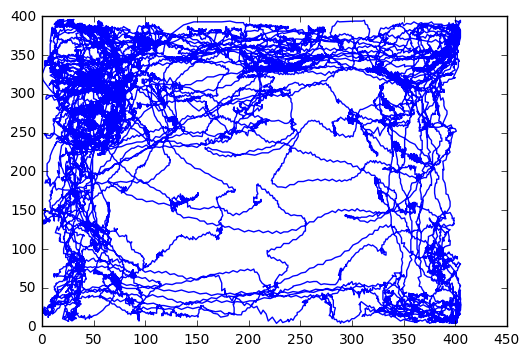

In [14]:
x = data[:,1]
y = data[:,2]
pos_bool = np.where((x != 1023) | (y != 1023))
plt.plot(x[pos_bool],y[pos_bool])

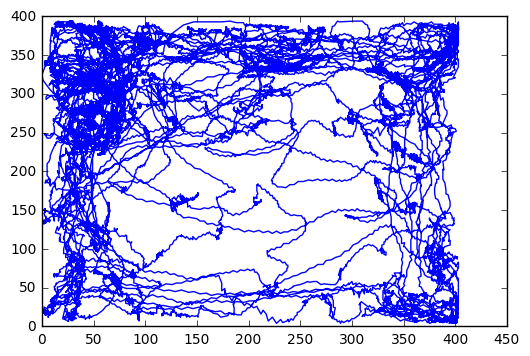

In [20]:
pos_fpath = 'E:\\Apollo_D_Drive\\ApolloKlusta\\ANT 200a3\\20171024-7-LargeBox-1400um-GAR_converted.pos'
posx, posy, post = getpos(pos_fpath, 'BehaviorRoom', 'raw')
pos_boolx = np.where((posx != 1023) | (posy != 1023))
plt.plot(posx[pos_boolx], posy[pos_boolx])